# Evaluation of dataset selection

In [1]:
number_of_features = [217,300,217,971,1618,785,785,6374,10001,10001,857,501,257,1301,1301,1777,279,1079,250,300,1101,401,241,4097,260,971,257,618,857,257]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

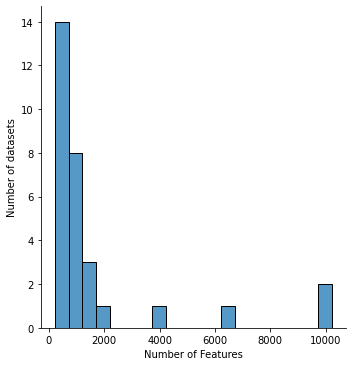

In [13]:
import seaborn as sns
ax = sns.displot(number_of_features, binwidth=500)
ax.set(xlabel='Number of Features', ylabel='Number of datasets')
ax.savefig('dataset_feature_distribution.eps')